## TMDB - Systematische Evaluierung

In [640]:
import pandas as pd
import numpy as np
from datetime import datetime

In [641]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

In [642]:
# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


In [643]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

# belongs_to_collection

In [644]:
# define columns that are not usefull
# adult is dropped because there are only 3 adult films. which makes it useless to use for our model
cols = [
    "imdbId",
    "Unnamed: 0",
    "backdrop_path",
    "homepage",
    "poster_path",
    "imdb_id",
    "original_title",
    "video",
    "tagline",
    "status",
    "adult",
    "vote_average",
    "vote_count",
    "popularity",
    "revenue",
    "budget",
    "belongs_to_collection"
]

# drop columns defined above
df_movies = df_movies.drop(df_movies[cols], axis=1)

In [645]:
# reorder columns for better overview
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "release_date", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
]

df_movies = df_movies[col_order]

In [646]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset=df_movies.columns.difference(["movieId"]))

# drop rows with runtime 30 --> remove short films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] < 30].index)

## Movie Ratings

In [647]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [648]:
lst_movieId = list(df_movies["movieId"])

# remove ratings from movies that we are not using
df_ratings = df_ratings[df_ratings["movieId"].isin(lst_movieId)]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

In [649]:
# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

In [650]:
# No user has rated the same movie twice
df_movies_ratings[df_movies_ratings.duplicated(subset=["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries


In [651]:
df_movies_ratings

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,United States of America
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,United States of America
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,United States of America
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,United States of America
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,United States of America
...,...,...,...,...,...,...,...,...,...,...,...
2636797,162067,150610,2.5,The Wicked Uncle,Drama|Comedy,"In a small Swiss village, a school sports coac...",100,de,Deutsch,,Germany|Switzerland
2636798,162067,159201,4.0,Toilet Stories,Comedy,Five toilets - five stories! This pitch black ...,91,de,Deutsch,,Germany
2636799,162067,188699,4.0,World Peace and Other 4th Grade Achievements,Documentary,Public school teacher John Hunter and his stud...,60,en,English,,
2636800,162067,193723,2.5,Vorwärts immer!,Comedy,NaN,98,de,Deutsch,Roxy Film|ARD|Crazy Film,Germany


In [652]:
# group by title and count ratings
df_movies_top_ratings = df_movies_ratings.groupby("title")["rating"].count().sort_values(ascending = False).reset_index()
df_movies_top_ratings

# show movies with more than 10 ratings (only 6.6k movies)
df_movies_10_ratings = df_movies_top_ratings[df_movies_top_ratings["rating"] > 10]
df_movies_10_ratings

,title,rating
0,Inception,38895
1,Interstellar,22634
2,Django Unchained,20686
3,The Dark Knight Rises,19911
4,Shutter Island,18886
...,...,...
6474,Killing Us Softly 4: Advertising's Image Of Women,11
6475,Bad Kids Go To Hell,11
6476,Chongqing Hot Pot,11
6477,Tees Maar Khan,11


#### Fragen

In [653]:
# Programmierungs Fragen
# tagline more relevant then overview?
# 300 + movies with 0 runtime
# amount of ratings --> drop movies with under 10 vote counts?? (results in 6600 movies)
# Many movies with 0 revenue and 0 budget

## Explorative Datenanalyse

In [654]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. Welches sind die am häufigsten geschauten Genres/Filme?


In [655]:
# separate genres and add them as columns, 0 = not in genre, 1 = in genre
dum = df_movies_ratings['genres'].str.get_dummies(sep = '|')
df_genres = pd.concat([df_movies_ratings, dum], axis=1)
df_genres.head()

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0


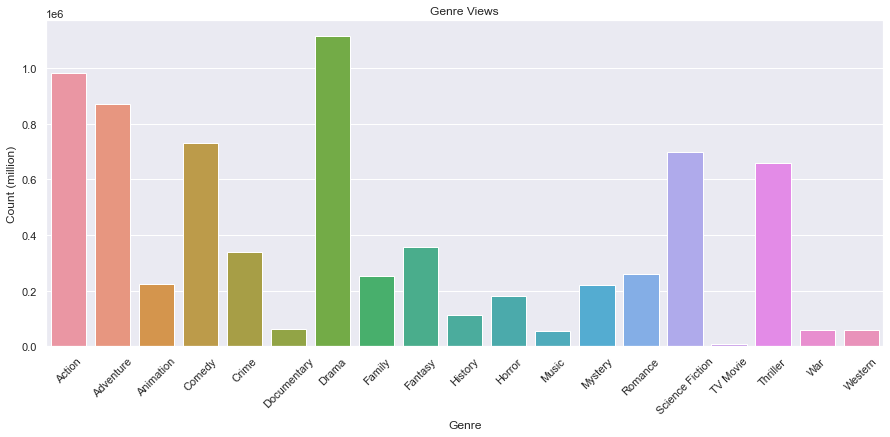

In [656]:
sns.set(rc={'figure.figsize':(15,6)})

ax = sns.barplot(data = df_genres.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)
ax.set(xlabel='Genre', ylabel='Count (million)', title="Genre Views")
plt.xticks(rotation = 45)
plt.show()

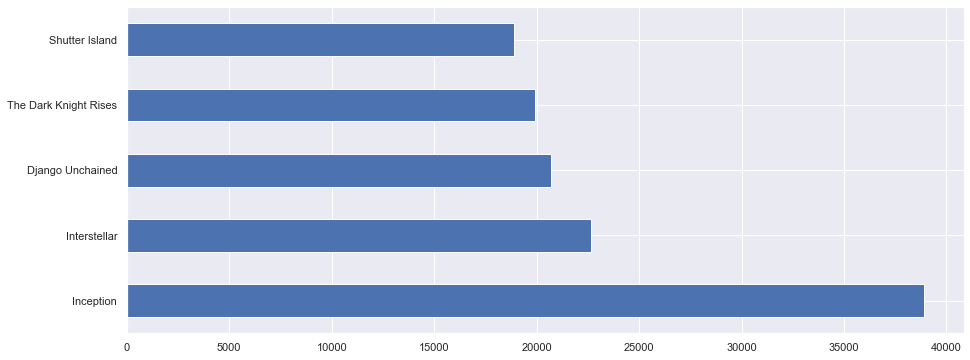

In [657]:
df_movies_ratings['title'].value_counts()[:5].plot(kind = "barh")
plt.show()

#### 2. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?


In [658]:
# create 2d list with genre and all ratings
lst2 = []
for i in df_genres.iloc[:,-19:].columns:
    lst2.append([i, df_genres[df_genres[i] == 1]["rating"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres_ratings = pd.DataFrame(lst2, columns = ["Genre", "Rating"])
df_genres_ratings = df_genres_ratings.explode("Rating")
df_genres_ratings.head()

,Genre,Rating
0,Action,4.0
0,Action,3.5
0,Action,3.0
0,Action,5.0
0,Action,5.0


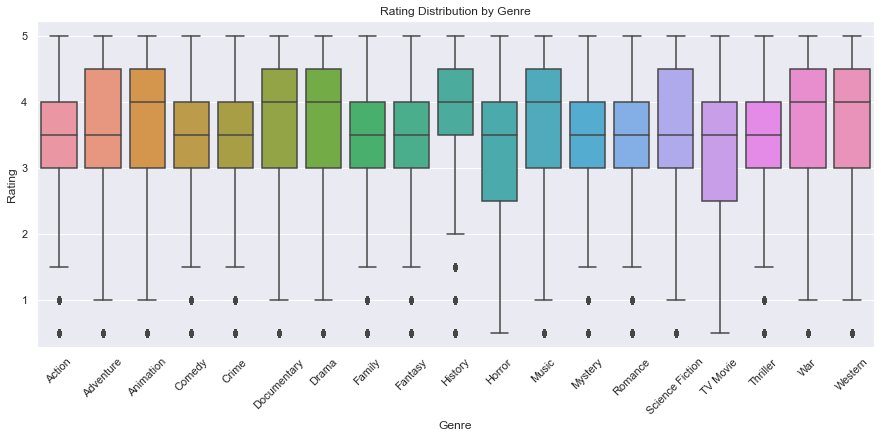

In [659]:
# plot rating by genre
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.boxplot(data = df_genres_ratings, x = "Genre", y = "Rating")
ax.set(xlabel='Genre', ylabel='Rating', title="Rating Distribution by Genre")
plt.xticks(rotation = 45)
plt.show()

#### 3. Wie verteilen sich die mittleren Kundenratings pro Film?

<AxesSubplot:ylabel='Frequency'>

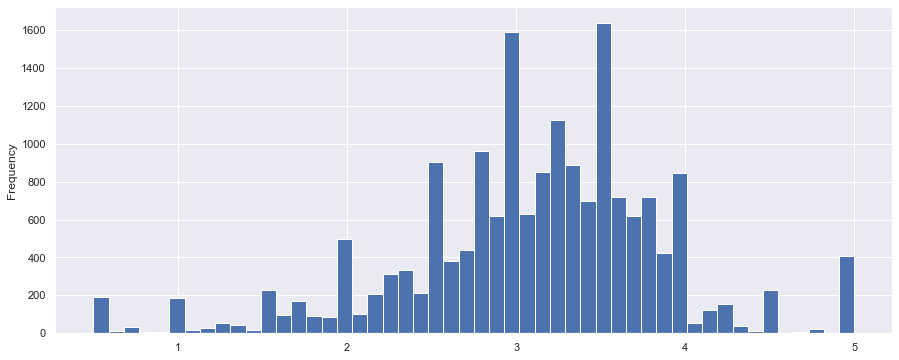

In [660]:
# group df4 by title and plot average rating
df_genres.groupby("title")["rating"].mean().sort_values(ascending = False).plot(kind = "hist", bins = 50)

#### 4. Wie stark streuen die Ratings von individuellen Kunden?

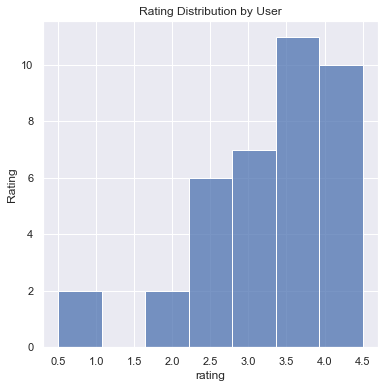

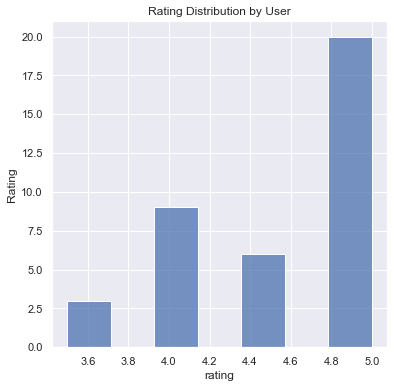

In [661]:
def user_rating(id):
    # seaborn boxplot ratings from random user
    sns.set(rc={'figure.figsize':(6,6)})

    ax = sns.histplot(data = df_genres[df_genres["userId"] == id], x = "rating")
    ax.set(ylabel='Rating', title="Rating Distribution by User")
    plt.show()

user_rating(13)
user_rating(44)

### NLP Implementierung

Was macht tf-idf mit Wörter, die überall vorkommen? 
- diese Wörter werden tief gewichtet

Was passiert mit Wörter die sehr selten sind? kann das Wort überahupt zur Ähnlichkeit beitragen?
- Wörter, die selten vorkommen haben ein höheres Score (höher bewertet)

Synonyme: Word2Vec (zb Auto --> PKW)

Verteilung der Ähnlichkeiten

aus dem text vektoren machen

was passiert mit dem cosinus similarity wenn wir die seltesten wörter abschneiden? besser? schlechter?

auf grund der häufigkeit matrix reduzieren

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

In [695]:
# show all movies that contain "marvel" in the production company
df_movies[df_movies["title"].str.contains("Spider")]

,movieId,title,genres,overview,release_date,runtime,original_language,spoken_languages,production_companies,production_countries
1163,95510,The Amazing Spider-Man,Action|Adventure|Fantasy,Peter Parker is an outcast high schooler aband...,2012-06-23,136,en,English,Columbia Pictures|Laura Ziskin Productions|Mar...,United States of America
2687,110553,The Amazing Spider-Man 2,Action|Adventure|Fantasy,"For Peter Parker, life is busy. Between taking...",2014-04-16,142,en,English,Columbia Pictures|Marvel Entertainment|Matt To...,United States of America
2767,111630,Big Ass Spider!,Science Fiction,When a giant alien spider escapes from a milit...,2013-10-17,80,en,English,Epic Pictures Group|Snowfort Pictures,United States of America
3028,114093,Camel Spiders,Horror|Science Fiction|Fantasy,Based on actual creatures that for years have ...,2011-03-04,80,en,English,Concorde-New Horizons|Factoria Corman,United States of America
4821,132352,Spiders,Science Fiction|Thriller,After a Soviet space station crashes into a Ne...,2013-02-08,89,en,English,Nu Image|Millennium Films,United States of America
6264,141355,Spiderwebhouse,Drama|Fantasy,When 12-year-old Jonas’ mother leaves to “figh...,2015-02-08,90,de,Deutsch,Südwestrundfunk|ARD|Tellux Film,Germany
7045,147740,The Red Spider,Thriller,"Karol, an ordinary young man, runs into a much...",2015-11-27,95,pl,Deutsch|Polski,Zentropa International Poland|PISF|Fog'n'Desir...,Czech Republic|Poland|Slovakia
7437,150042,Little Black Spiders,Drama,"Belgium, 1978. Katja, Roxy, and a group of oth...",2012-09-19,90,nl,Nederlands,,Belgium
14224,185129,Spider Thieves,Drama,Three teenage girls from a Santiago shanty tow...,2017-05-18,94,es,Español,Altiro Sapiens,Chile
16362,193647,The Girl in the Spider's Web,Action|Crime|Thriller|Drama,After being enlisted to recover a dangerous co...,2018-10-25,115,en,English,Columbia Pictures|Metro-Goldwyn-Mayer|Sony Pic...,Canada|Germany|Sweden|United Kingdom|United St...


In [663]:
# set random seed
np.random.seed(42)

# create dataframe with 2 movies for testing
df_movies_20 = df_movies.sample(15000).reset_index(drop = True)

In [664]:
# replace all nan with space entire dataframe
df_movies_20 = df_movies_20.fillna(" ")

In [715]:
cols = [
    "title", "title",
    "genres", "genres", "genres", "genres",
    "overview",
    "spoken_languages",
    "original_language", "original_language",
    "production_companies", "production_companies",
    "production_countries"
]

df_movies_20["tfidf"] = df_movies_20[cols].apply(" ".join, axis=1)
df_movies_20["tfidf"]

0        The Surface The Surface Thriller|Drama Thrille...
1        Lost River Lost River Fantasy|Thriller|Drama F...
2        Siren Siren Horror Horror Horror Horror A bach...
3        Gun Shy Gun Shy Action|Adventure|Comedy|Crime|...
4        Text Text Drama|Thriller Drama|Thriller Drama|...
                               ...                        
14995    A Bread Factory: Part Two A Bread Factory: Par...
14996    Joy in the World Joy in the World Comedy|Drama...
14997    Disobedience Disobedience Drama|Romance Drama|...
14998    The Night Sitter The Night Sitter Comedy|Horro...
14999    Listen to Me Marlon Listen to Me Marlon Docume...
Name: tfidf, Length: 15000, dtype: object

### Pre-Processing Data

In [716]:
from nltk.stem.snowball import SnowballStemmer

# lowercase column overview
df_movies_20["tfidf"] = df_movies_20["tfidf"].str.lower()

# remove punctuation from overview
symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"

# replace all punctuations from overview with space
for i in symbols:
    df_movies_20["tfidf"] = df_movies_20["tfidf"].str.replace(i, ' ')
    
# replace all single words from overview with space
df_movies_20["tfidf"] = df_movies_20["tfidf"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')

stemmer = SnowballStemmer("english")

df_movies_20["tfidf"] = df_movies_20["tfidf"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
df_movies_20["tfidf"].head()

C:\Users\Alex\AppData\Local\Temp/ipykernel_13340/726154119.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_movies_20["tfidf"] = df_movies_20["tfidf"].str.replace(i, ' ')
C:\Users\Alex\AppData\Local\Temp/ipykernel_13340/726154119.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_movies_20["tfidf"] = df_movies_20["tfidf"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')


0    the surfac the surfac thriller drama thriller ...
1    lost river lost river fantasi thriller drama f...
2    siren siren horror horror horror horror bachel...
3    gun shi gun shi action adventur comedi crime t...
4    text text drama thriller drama thriller drama ...
Name: tfidf, dtype: object

## TF-IDF
TfidfVectorizer --> convert a collection of text documents to a matrix of TF-IDF features
- Welche Gewichtung hat das Wort im Overview --> df_tfidf_vect

CountVectorizer --> convert a collection of text documents to a vector of term / token counts
- Zählt, ob das Wort im Overview vorkommt

In [717]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

count_vectorizer = CountVectorizer(stop_words="english", analyzer = "word")
tfidf_vectorizer = TfidfVectorizer(stop_words="english", analyzer = "word", ngram_range=(1, 2))

tfidf = tfidf_vectorizer.fit_transform(df_movies_20["tfidf"])

sparse_matrix = sparse.csr_matrix(tfidf)

print(sparse_matrix.shape)

(15000, 472024)


In [729]:
# calculate the cosine similarity
cosine_sim = cosine_similarity(sparse_matrix)

# recommend most similar movies
def recommend_movies(title, cosine_sim = cosine_sim):
    try:
        # get the index of the movie that matches the title
        idx = df_movies_20[df_movies_20["title"] == title].index[0]

        # create a Series with the similarity scores in descending order
        score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
        
        # get the indexes of the 5 most similar movies
        top_10_indexes = list(score_series.iloc[1:10].index)
        
        # Populate the list with the titles of the best 10 matching movies
        for i in top_10_indexes:
            print(df_movies_20.iloc[i]["title"], ":", score_series[i])
    except:
        print("Movie not found")

recommend_movies("Fast & Furious 6")

Furious 7 : 0.24162397946173117
The Fate of the Furious : 0.1810342076488582
Fast Five : 0.17065340063772316
Trainwreck : 0.1315080750046286
Restitution : 0.13092630188900728
Manhunt : 0.1294424191092868
Yuddham Sei : 0.12819624681455496
The November Man : 0.11901153126910667
The Terror Live : 0.11890116472279653


### Welche Wörter kommen am häufigsten vor?

In [719]:
word_count_matrix = count_vectorizer.fit_transform(df_movies_20["tfidf"])
word_array = count_vectorizer.get_feature_names_out()

print([word_array[i] for i in np.argsort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5]])
print(np.sort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5])

['drama', 'film', 'comedi', 'thriller', 'documentari']
[26438, 18778, 17760, 11472, 10802]


### Cosine Similarity
![Getting Started](./cosine_similarity.png)

In [720]:
# print overviews from selected movies
# df_movies[df_movies["title"].isin(["Interstellar", "Immortals"])][["title", "overview"]].values

In [721]:
### tfidf gewichtung
### word2vec ein vektor für ein einzelnes wort
### embedings und global average

## User Profiles
300 Top Users --> in 10 Gruppen aufteilen

In [722]:
# how many unique user ids are there in df_movie_ratings
df_movies_ratings["userId"].nunique()

# get the 300 users with the most ratings
top_300_users = df_movies_ratings["userId"].value_counts().head(300).index.tolist()

# create a dataframe with the top 300 users and their movie ratings
df_top_300_users = df_movies_ratings[df_movies_ratings["userId"].isin(top_300_users)]

In [723]:
# create user-liked-movie matrix with userid as index and movieid as columns and rating as values
df_user_movie_matrix = df_top_300_users.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)
df_user_movie_matrix.head()

movieId,2679,4249,4484,5904,47237,47962,71677,72491,73319,73321,...,208717,208737,208747,208779,208787,208793,208800,208915,208939,209051
userId,,,,,,,,,,,,,,,,,,,,,
548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0
1748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [724]:
# create user-item-liked matrix (> 3 rating = 1, else 0)
df_top_300_users["liked"] = np.where(df_top_300_users["rating"] > 3, 1, 0)

C:\Users\Alex\AppData\Local\Temp/ipykernel_13340/1221121544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_300_users["liked"] = np.where(df_top_300_users["rating"] > 3, 1, 0)


In [725]:
# create user-item matrix
df_user_item = df_top_300_users.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)
df_user_item.head()

# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# calculate the cosine similarity
cosine_sim = cosine_similarity(df_user_item)

# create a dataframe with the cosine similarity
df_cosine_sim = pd.DataFrame(cosine_sim, index = df_user_item.index, columns = df_user_item.index)
df_cosine_sim.head()

userId,548,997,1652,1748,2389,3150,3394,3484,4019,4429,...,156090,156183,156480,157804,157975,158028,158109,160747,162047,162271
userId,,,,,,,,,,,,,,,,,,,,,
548,1.000000,0.384613,0.370225,0.323324,0.259359,0.405081,0.297382,0.390359,0.335708,0.295356,...,0.412437,0.384304,0.296749,0.436046,0.293923,0.257400,0.377168,0.354843,0.296405,0.229355
997,0.384613,1.000000,0.479997,0.438847,0.400312,0.462656,0.360744,0.468570,0.510313,0.450943,...,0.469532,0.512994,0.407756,0.460543,0.410971,0.339368,0.503104,0.364064,0.309992,0.359084
1652,0.370225,0.479997,1.000000,0.333717,0.346262,0.433428,0.295440,0.350404,0.407638,0.349787,...,0.379027,0.438713,0.326134,0.398412,0.399369,0.289002,0.410435,0.399166,0.361260,0.305361
1748,0.323324,0.438847,0.333717,1.000000,0.250292,0.355018,0.201107,0.312626,0.395452,0.334007,...,0.459689,0.376571,0.286892,0.382896,0.308235,0.371811,0.328574,0.279354,0.257866,0.279851
2389,0.259359,0.400312,0.346262,0.250292,1.000000,0.361288,0.328840,0.214187,0.323559,0.276162,...,0.309197,0.341220,0.344391,0.334630,0.293497,0.264030,0.251021,0.385904,0.253398,0.385181


In [726]:
# get the 5 most similar users to user 13 using iloc
df_cosine_sim.iloc[1].sort_values(ascending = False).head(6)

userId
997       1.000000
132358    0.618318
111038    0.614743
58885     0.609959
124974    0.607793
19886     0.598325
Name: 997, dtype: float64

In [727]:
# divide df_cosine_sim into 10 groups of most similar users using iloc

## Word2Vec
## Doc2Vec

## Evaluierung


In [728]:
# auswertung ob das modell gut ist